# Imports

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install PIL
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install open3d

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
import open3d as o3d
import copy

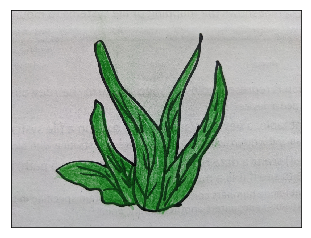

In [3]:
orig_img = cv2.imread('photos/seaweed.jpg')
h_orig,w_orig,chn = orig_img.shape
#Do a resize so the largest dimension is not greater than 800

scale = 1
if (h_orig > 800 or w_orig > 800):
    scale = 800/max(h_orig, w_orig) #should be less than 1

newsize = ((int)(w_orig*scale),(int)(h_orig*scale)) 
scale_img = cv2.resize(orig_img, newsize, interpolation = cv2.INTER_AREA)

h,w,chn = scale_img.shape

#original image
plt.imshow(scale_img[:,:,::-1]) #pyplot is BGR not RGB
plt.xticks([]), plt.yticks([])
plt.show()

# Image to Vertices

## OpenCV GrabCut

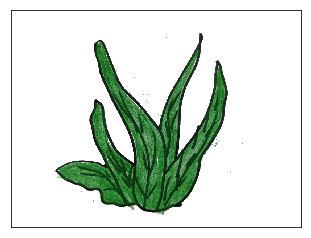

In [4]:
mask = np.zeros(scale_img.shape[:2],np.uint8)

img = scale_img

#Replace shades of white to white (thresholding)
img[np.where((img>=[150,150,150]).all(axis=2))] = [255,255,255]

#cv2.imwrite('img_whitened.png', img)
plt.imshow(img[:,:,::-1]) #pyplot is BGR not RGB
plt.xticks([]), plt.yticks([])
plt.show()

image size (600, 800, 3)
done with grabcut, saving image


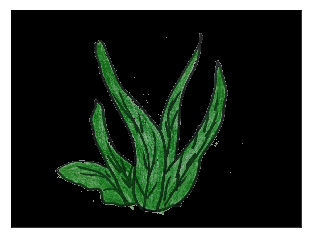

In [5]:
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

print("image size", img.shape)
# This frame may need some work. Not sure how to estimate a good window
rect = ((int)(.05 * w), (int)(.05* h), (int)(.9*w), (int)(.9*h)) #(start_x, start_y, width, height)

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
# 0-pixels and 2-pixels are put to 0 (ie background) and all 1-pixels and 3-pixels are put to 1(ie foreground pixels).
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

#Improvement, make sure the threshold we sent makes the mask set to background
mask2[np.where((img>=[150,150,150]).all(axis=2))] = 0

'''
OpenCV grabcut takes the input image, mask and rectangle for object, background model, foregound model, 
amount of iterations to run, and mode

Mask is changed so that all 0 & 2 pixels are converted to background, 1 and 3 are foreground. 
Multiply with input image and get result.
'''

img = img*mask2[:,:,np.newaxis]

print("done with grabcut, saving image")
#cv2.imwrite('cropped_fish_test.png', img)

plt.imshow(img[:,:,::-1]) #pyplot is BGR not RGB
plt.xticks([]), plt.yticks([])
plt.show()

## Contouring

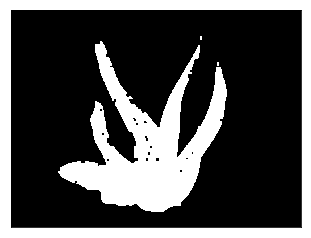

In [6]:
#Import image
gwash = img #cv2.imread("cropped_fish_test.png") #import image
gwashBW = cv2.cvtColor(gwash, cv2.COLOR_BGR2GRAY) #change to grayscale

ret,thresh1 = cv2.threshold(gwashBW,0,255,cv2.THRESH_BINARY) #0 because we already cropped
kernel = np.ones((5,5),np.uint8) #square image kernel used for erosion
erosion = cv2.erode(thresh1, kernel,iterations = 1) #refines all edges in the binary image

opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) #this is for further removing small noises and holes in the image

plt.imshow(closing, 'gray') #Figure 2
plt.xticks([]), plt.yticks([])
plt.show()

In [7]:
print("starting contour")
contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #find contours with simple approximation

dst = np.zeros((closing.shape[1], closing.shape[0]),np.uint8)  

cv2.drawContours(dst, contours, -1, (255, 255, 255), 1)
cv2.imshow('cleaner', dst) 
cv2.waitKey(0)

# Or find contours and do all the points
contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
dst = np.zeros((closing.shape[1], closing.shape[0]),np.uint8)  

cv2.drawContours(dst, contours, -1, (255, 255, 255), 1)
cv2.imshow('cleaner', dst) 
cv2.waitKey(0)

starting contour


-1

### Get only the largest area contour

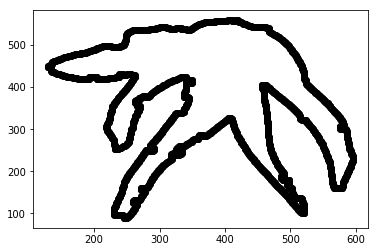

In [16]:
#Get only the largest area
areas = [] #list to hold all areas

for contour in contours:
    areas.append(cv2.contourArea(contour))

max_area = max(areas)
max_area_index = areas.index(max_area) #index of the list element with largest area

cnt = contours[max_area_index] #largest area contour

dst = np.zeros((closing.shape[1], closing.shape[0]),np.uint8)

format_contour_x = [x[0][0] for x in contours[max_area_index]]
format_contour_y = [x[0][1] for x in contours[max_area_index]]
#format_contour_y.reverse()
plt.plot(format_contour_x, format_contour_y, 'o', color='black');

### Delauney

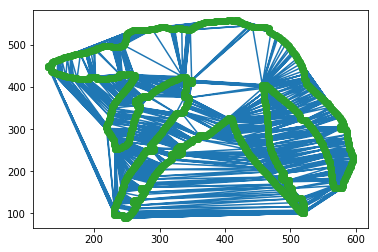

[[245  89]
 [245  90]
 [245  91]
 ...
 [417 558]
 [418 558]
 [419 558]]


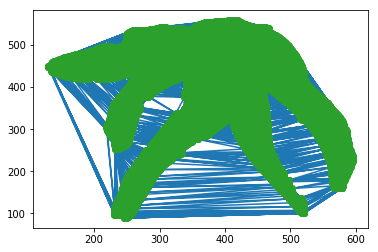

In [17]:
from scipy.spatial import Delaunay
zipped = list(zip(format_contour_x, format_contour_y))
zipped = np.array([list(x) for x in zipped])

tri = Delaunay(zipped)
plt.triplot(zipped[:,0], zipped[:,1], tri.simplices)
plt.plot(zipped[:,0], zipped[:,1], 'o')
plt.show()

#Try filling in the points
zipped_all_pts = list(zip(format_contour_x, format_contour_y))
for i in range(closing.shape[0]):
    for j in range(closing.shape[1]):
        inBBx = cv2.pointPolygonTest(contours[max_area_index], (j,i), False)
        if inBBx == 1: #inside
            zipped_all_pts.append([j,i])
        #else is 0 or -1 which is on edge or outside

# zipped_all_pts = np.array([list(x) for x in zipped_all_pts])
# print(zipped_all_pts)
# tri = Delaunay(zipped_all_pts)
# plt.triplot(zipped_all_pts[:,0], zipped_all_pts[:,1], tri.simplices)
# plt.plot(zipped_all_pts[:,0], zipped_all_pts[:,1], 'o')
# plt.show()

## Store in format for point cloud algo

In [18]:
#colors, from original image
def get_color(pt_x, pt_y, orig_img):
    if(pt_x >= w or pt_x < 0): 
        return [0, 0, 0]
    elif(pt_y >= h or pt_y < 0):
        return [0, 0, 0]
    else:
        return (orig_img[pt_y][pt_x])[::-1]
    
'''
Input: points will be [[x, y],[x, y]...] format
Output: (width, length, trans_x_to_origin, trans_y_to_origin)
'''
def get_width_and_length_and_trans(points):
    #Since we know points will always be positive, we don't need to take the absolute distance
    width = max([x[0] for x in points]) - min([x[0] for x in points])
    length = max([x[1] for x in points]) - min([x[1] for x in points])
    trans_x = min([x[0] for x in points])
    trans_y = min([x[1] for x in points])
    
    return (width, length, trans_x, trans_y)

'''
Point will be x, y in 2D
w_l_trans in format same as get_width_and_length_and_trans function
   (width, length, trans_x_to_origin, trans_y_to_origin)
'''
def move_to_origin(point, w_l_trans):
    width = w_l_trans[0]
    height = w_l_trans[1]
    return [point[0]-(width/2)-w_l_trans[2], point[1]-(height/2)-w_l_trans[3]]

#As you can see normals hardcoded, probably not entirely right but works well enough
normal = [0, 0, 1] 
normal_down = [0, 0, -1]
dummy_color = [0, 255, 255] #dummy color
dummy_neg_z = -10.0
dummy_pos_z = 10.0

data = []
w_l_trans = get_width_and_length_and_trans(zipped_all_pts)

#zipped_all_pts used to be countours[max_area_index] but mesh reconstruction using these algorithms do not work as well.
for x in zipped_all_pts:
    #print(x) #each is in a [x y] format?
    #print(x)
    point_color = get_color(x[0], x[1], scale_img)
    moved_pt = move_to_origin(x, w_l_trans)
    
    points_neg = [moved_pt[0], moved_pt[1], dummy_neg_z, point_color[0], point_color[1], point_color[2], normal_down[0], normal_down[1], normal_down[2]]
    data.append(points_neg)
    points_pos = [moved_pt[0], moved_pt[1], dummy_pos_z, point_color[0], point_color[1], point_color[2], normal[0], normal[1], normal[2]]
    data.append(points_pos)
    
print("done")

done


In [19]:
f = open("jupyter_point_mesh.txt", "w")
f.write("X Y Z R G B Nx Ny Nz\n")
for i in data:
    str_ver =  map(str,i)
    f.write(' '.join(str_ver))
    f.write('\n')

f.close()

# Verticies to Triangle Mesh (obj)

In [20]:
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

input_path=""
output_path=""
dataname="jupyter_point_mesh.txt" 
point_cloud= np.loadtxt(input_path+dataname,skiprows=1)

pcd = o3d.geometry.PointCloud() #make point cloud object
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(point_cloud[:,3:6]/255)
pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,6:9]) 

# pcd.normals = o3d.utility.Vector3dVector(np.zeros( (1, 3)))  # invalidate existing normals
# pcd.estimate_normals()
# pcd.orient_normals_consistent_tangent_plane(100)

#Show point cloud
o3d.visualization.draw_geometries([pcd])
#Show normals
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [24]:
#Meshing 

scale = 0.0001

# print("BPA meshing")
# #BPA
# distances = pcd.compute_nearest_neighbor_distance()
# avg_dist = np.mean(distances)
# radius = 2 * avg_dist #changed from 3*
# bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
# bpa_mesh.scale(scale, center=bpa_mesh.get_center())
# print("BPA triangle number", len(bpa_mesh.triangles))

# #Simplifying bpa mesh
# dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)
# dec_mesh.remove_degenerate_triangles()
# dec_mesh.remove_duplicated_triangles()
# dec_mesh.remove_duplicated_vertices()
# dec_mesh.remove_non_manifold_edges()
# dec_mesh.scale(scale, center=dec_mesh.get_center())
# print("BPA simplified triangle number", len(dec_mesh.triangles))

print("Poisson meshing")
#Poisson
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
poisson_mesh.scale(scale, center=poisson_mesh.get_center())

#Rotate because opencv image is upside down
R = poisson_mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
poisson_mesh.rotate(R, center=(0, 0, 0))
#o3d.visualization.draw_geometries([poisson_mesh])


bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
print("poisson triangle number", len(poisson_mesh.triangles))

#Export
print("exporting...")
poisson_mesh = copy.deepcopy(poisson_mesh).translate((0, 0, 0), relative=False)
p_mesh_crop = copy.deepcopy(p_mesh_crop).translate((0, 0, 0), relative=False)
poisson_mesh = poisson_mesh.compute_triangle_normals();
p_mesh_crop = p_mesh_crop.compute_triangle_normals();

#types, obj, ply, stl, gltf
# o3d.io.write_triangle_mesh(output_path+"bpa_mesh_simp_fish_test.obj", dec_mesh)
o3d.io.write_triangle_mesh(output_path+"jupyter_model.gltf", poisson_mesh)
# o3d.io.write_triangle_mesh(output_path+"bpa_mesh_fish_test.obj", bpa_mesh)
#o3d.io.write_triangle_mesh(output_path+"p_mesh_c_fish_test_n.obj", p_mesh_crop)
print("done exporting")

Poisson meshing
poisson triangle number 116848
exporting...
done exporting


In [13]:
#LoD makes lower quality meshes with less traingles for you, and saves based on the desired output
#You can change by adding to array i. e [10000, 1000, 100]
my_lods = lod_mesh_export(bpa_mesh, [10000], ".obj", output_path)

print("done with my lods")

[Open3D WARNING] Write OBJ can not include triangle normals.
generation of 10000 LoD successful
done with my lods


In [22]:
#Poisson
#LoD makes lower quality meshes with less traingles for you, and saves based on the desired output
#You can change by adding to array i. e [10000, 1000, 100]

# Reduce by 1000 seem to be the best, gltf saves pixels
my_lods = lod_mesh_export(poisson_mesh, [10000], ".glb", output_path)

print("done with my lods")

generation of 10000 LoD successful
done with my lods
